### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Western_Ghats/WesternGhats_CLEANED"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]11:47:11 Initiating the NLP Engine
[INFO]11:47:11 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Western_Ghats/WesternGhats_CLEANED.txt is being ported to dataframe
[INFO]11:47:11 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Western_Ghats/WesternGhats_CLEANED.txt has been ported to dataframe
[INFO]11:47:11 Trimming data and preparing list of words
[["Abstract: 'Earth Observation with large suite of sensors and with capabilities to address natural resources at multiple scales has proven to be a critical resource in setting conservation priorities of a region. The role of earth observation data was recognized towards achieving international biodiversity targets by 2020. Ecosystem irreplaceability and ecosystem vulnerability are two concepts key to understanding and preparing conservation priority maps. This study presents spatial conservation prioritization analysis for forests of Ghats biodiversity Earth observation data products have been used for prioritiza

[INFO]11:47:12 Generating bigrams
[INFO]11:47:12 Generating word bigrams
[INFO]11:47:14 Generated word bigrams
[INFO]11:47:15 Beginning lemmatization
[INFO]11:47:26 Ending lemmatization
[INFO]11:47:41 Issued perplexity: -9.697496633522086
[INFO]11:47:41 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.036*"element" + 0.031*"concern" + 0.026*"predict" + 0.025*"animal" + 0.021*"link" + 0.020*"mammal" + 0.018*"space" + 0.017*"female" + 0.017*"socio_economic" + 0.015*"ecologically"'),
 (1,
  '0.024*"extract" + 0.019*"chemical" + 0.018*"report" + 0.017*"activity" + 0.014*"material" + 0.014*"property" + 0.014*"treat" + 0.012*"isolate" + 0.012*"seasonal" + 0.011*"new"'),
 (2,
  '0.008*"refuge" + 0.007*"camera" + 0.006*"ungulate" + 0.006*"trapping" + 0.004*"occupancy" + 0.002*"detection_probability" + 0.000*"chevrotain" + 0.000*"fireback" + 0.000*"rattus" + 0.000*"galliforme"'),
 (3,
  '0.015*"forest" + 0.012*"india" + 0.010*"conservation" + 0.010*"land" + 0.009*"management" + 0.009*"change" + 0.007*"resource" + 0.007*"development" + 0.007*"cover" + 0.007*"datum"'),
 (4,
  '0.030*"male" + 0.028*"group" + 0.018*"adult" + 0.018*"crucial" + 0.017*"gender" + 0.015*"preference" + 0.014*"daily" + 0.013*"macaque" + 0.012*"size" + 0.012*"other"'),
 (5,
  '0.044*"forest" + 0.022*"xa" + 0.0

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(num_topics = -1, formatted=False))

[(0,
  [('increase', 0.015808617795187465),
   ('time', 0.014759373251259093),
   ('group', 0.013780078343592614),
   ('result', 0.013710128707330722),
   ('effect', 0.01266088416340235),
   ('year', 0.011891438164521545),
   ('show', 0.011751538891997761),
   ('size', 0.011681589255735871),
   ('influence', 0.011681589255735871),
   ('significant', 0.01119194180190263)]),
 (1,
  [('tree', 0.051019847160371654),
   ('forest', 0.04299301775798559),
   ('site', 0.0313925999230304),
   ('diversity', 0.028368794326241134),
   ('density', 0.02529001044587388),
   ('richness', 0.01946231238660729),
   ('high', 0.014239375446698553),
   ('index', 0.01412941887954258),
   ('structure', 0.01313980977513882),
   ('total', 0.01264500522293694)]),
 (2,
  [('conservation', 0.06410955583833243),
   ('biodiversity', 0.031085257225958916),
   ('habitat', 0.027510149669757015),
   ('human', 0.017511967521056777),
   ('protect', 0.013936859964854874),
   ('natural', 0.011937223535114828),
   ('endemic',

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5265604494272261


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

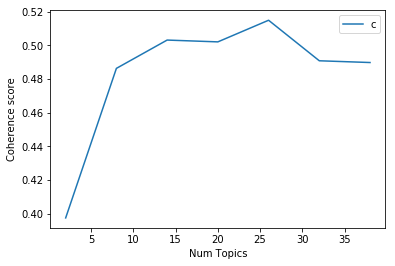

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)
print(model_topics)

[(2, [('conservation', 0.06410955583833243), ('biodiversity', 0.031085257225958916), ('habitat', 0.027510149669757015), ('human', 0.017511967521056777), ('protect', 0.013936859964854874), ('natural', 0.011937223535114828), ('endemic', 0.011391868145185724), ('western_ghats', 0.011088892928558443), ('ecological', 0.010664727625280252), ('large', 0.010179967278676604)]), (11, [('water', 0.05334479111581174), ('river', 0.02141723955579059), ('india', 0.016657852987837122), ('groundwater', 0.014410364886303543), ('zone', 0.014278159703860392), ('major', 0.01414595452141724), ('region', 0.013683236382866209), ('quality', 0.012162876784769964), ('energy', 0.011634056054997356), ('flow', 0.011435748281332628)]), (5, [('india', 0.028367812910814364), ('distribution', 0.02393966650522383), ('region', 0.020895315851380335), ('indian', 0.01605203072026569), ('southern', 0.01280011070366014), ('range', 0.01079360686362693), ('south', 0.010378468138102816), ('occurrence', 0.009409811111879886), ('s

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.016*"increase" + 0.015*"time" + 0.014*"group" + 0.014*"result" + '
  '0.013*"effect" + 0.012*"year" + 0.012*"show" + 0.012*"influence" + '
  '0.012*"size" + 0.011*"significant" + 0.011*"pattern" + 0.011*"seed" + '
  '0.010*"fruit" + 0.010*"period" + 0.010*"growth" + 0.008*"activity" + '
  '0.007*"season" + 0.007*"investigate" + 0.007*"suggest" + 0.007*"control" + '
  '0.007*"day" + 0.007*"difference" + 0.006*"dry" + 0.006*"test" + '
  '0.006*"elephant" + 0.006*"important" + 0.006*"natural" + 0.006*"reduce" + '
  '0.006*"factor" + 0.005*"harvest" + 0.005*"level" + 0.005*"temperature" + '
  '0.005*"male" + 0.005*"ant" + 0.005*"role" + 0.005*"seasonal" + '
  '0.005*"flower" + 0.005*"age" + 0.005*"food" + 0.005*"strong"'),
 (1,
  '0.051*"tree" + 0.043*"forest" + 0.031*"site" + 0.028*"diversity" + '
  '0.025*"density" + 0.019*"richness" + 0.014*"high" + 0.014*"index" + '
  '0.013*"structure" + 0.013*"total" + 0.011*"tropical" + 0.011*"type" + '
  '0.011*"range" + 0.010*"individual

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2250,"forest, change, cover, land, area, increase, l...",[Abstract: 'Earth Observation with large suite...
1,1,9.0,0.3311,"forest, change, cover, land, area, increase, l...",[Abstract: 'In fast-changing tropical landscap...
2,2,1.0,0.3676,"tree, forest, site, diversity, density, richne...",[Abstract: 'We assessed the distribution and a...
3,3,2.0,0.4097,"conservation, biodiversity, habitat, human, pr...",[Abstract: 'Hill forts of Northern Western Gha...
4,4,2.0,0.0975,"conservation, biodiversity, habitat, human, pr...","[hotspot, Tamil Nadu, India']"
5,5,1.0,0.3877,"tree, forest, site, diversity, density, richne...",[Abstract: 'This study highlights spatial char...
6,6,1.0,0.2623,"tree, forest, site, diversity, density, richne...",[Abstract: 'Seventy one fish species belonging...
7,7,0.0,0.5365,"increase, time, group, result, effect, year, s...",[Abstract: 'In order to understand the vegetat...
8,8,11.0,0.0882,"water, river, india, groundwater, zone, major,...",[India']
9,9,3.0,0.5668,"population, genetic, analysis, diversity, vari...","[Abstract: ' Decalepis arayalpathra, a critica..."


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9.0,"forest, change, cover, land, area, increase, l...",200.0,0.0959
1,9.0,"forest, change, cover, land, area, increase, l...",185.0,0.0887
2,1.0,"tree, forest, site, diversity, density, richne...",158.0,0.0757
3,2.0,"conservation, biodiversity, habitat, human, pr...",175.0,0.0839
4,2.0,"conservation, biodiversity, habitat, human, pr...",196.0,0.0940
5,1.0,"tree, forest, site, diversity, density, richne...",176.0,0.0844
6,1.0,"tree, forest, site, diversity, density, richne...",227.0,0.1088
7,0.0,"increase, time, group, result, effect, year, s...",137.0,0.0657
8,11.0,"water, river, india, groundwater, zone, major,...",196.0,0.0940
9,3.0,"population, genetic, analysis, diversity, vari...",172.0,0.0825


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      32.538528        1       1 -0.279091  0.037538
5      21.111580        1       2 -0.265366  0.048083
10     14.326434        1       3 -0.212822  0.134015
7      11.048706        1       4 -0.184750  0.094763
11      6.299405        1       5 -0.056081 -0.287659
6       5.806489        1       6 -0.010434 -0.188795
1       3.845307        1       7  0.045625 -0.135012
9       1.634196        1       8  0.184389  0.051941
0       1.204636        1       9  0.195515  0.066085
8       1.062479        1      10  0.198899  0.067893
4       0.988709        1      11  0.190542  0.064116
2       0.133527        1      12  0.193575  0.047031, topic_info=      Category         Freq            Term        Total  loglift  logprob
9484   Default  2872.000000          forest  2872.000000  30.0000  30.0000
594    Default  1321.000000           plant  1321.000000  29.0000  29.0000
1609   Default   898.000000           water   898.000000  28.0000  28.0000
5741   Default  1145.000000              xa  1145.000000  27.0000  27.0000
10929  Default   836.000000      population   836.000000  26.0000  26.0000
12939  Default   463.000000           group   463.000000  25.0000  25.0000
11562  Default   859.000000           model   859.000000  24.0000  24.0000
1979   Default   922.000000            tree   922.000000  23.0000  23.0000
4631   Default   786.000000       diversity   786.000000  22.0000  22.0000
11869  Default   495.000000         genetic   495.000000  21.0000  21.0000
8895   Default  1024.000000            soil  1024.000000  20.0000  20.0000
202    Default   788.000000        analysis   788.000000  19.0000  19.0000
6654   Default   315.000000            root   315.000000  18.0000  18.0000
2383   Default   355.000000        activity   355.000000  17.0000  17.0000
13749  Default   263.000000           shoot   263.000000  16.0000  16.0000
16140  Default   295.000000            crop   295.000000  15.0000  15.0000
600    Default   259.000000              mg   259.000000  14.0000  14.0000
4239   Default  1493.000000           india  1493.000000  13.0000  13.0000
13599  Default   258.000000            size   258.000000  12.0000  12.0000
8980   Default   272.000000       knowledge   272.000000  11.0000  11.0000
7510   Default   767.000000            high   767.000000  10.0000  10.0000
567    Default   261.000000          report   261.000000   9.0000   9.0000
10337  Default   447.000000          energy   447.000000   8.0000   8.0000
12593  Default   140.000000            fire   140.000000   7.0000   7.0000
6576   Default   521.000000            site   521.000000   6.0000   6.0000
4771   Default   832.000000            land   832.000000   5.0000   5.0000
9589   Default   331.000000             new   331.000000   4.0000   4.0000
8328   Default   133.000000         improve   133.000000   3.0000   3.0000
11936  Default   186.000000         extract   186.000000   2.0000   2.0000
4455   Default   353.000000            zone   353.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
6659   Topic12     0.016289      visibility     0.828941   2.6890  -9.7270
1911   Topic12     0.016290        pristine     0.829761   2.6880  -9.7270
12983  Topic12     0.016049      mouse_deer     0.819707   2.6853  -9.7419
13789  Topic12     0.016273    ectoparasite     0.833329   2.6827  -9.7280
14572  Topic12     0.016000         elusive     0.819379   2.6827  -9.7449
3757   Topic12     0.016090         persian     0.827019   2.6790  -9.7393
5624   Topic12     0.016090           qeshm     0.827019   2.6790  -9.7393
7330   Topic12     0.016090            flea     0.827019   2.6790  -9.7393
4502   Topic12     0.016090         iranian     0.827019   2.6790  -9.7393
587    Topic12     0.016289        observer     0.837315   2.6789  -9.7270
862    Topic12     0.015948             yak     0.8

In [38]:
topics = optimal_model.show_topics(num_topics = -1, formatted=False)

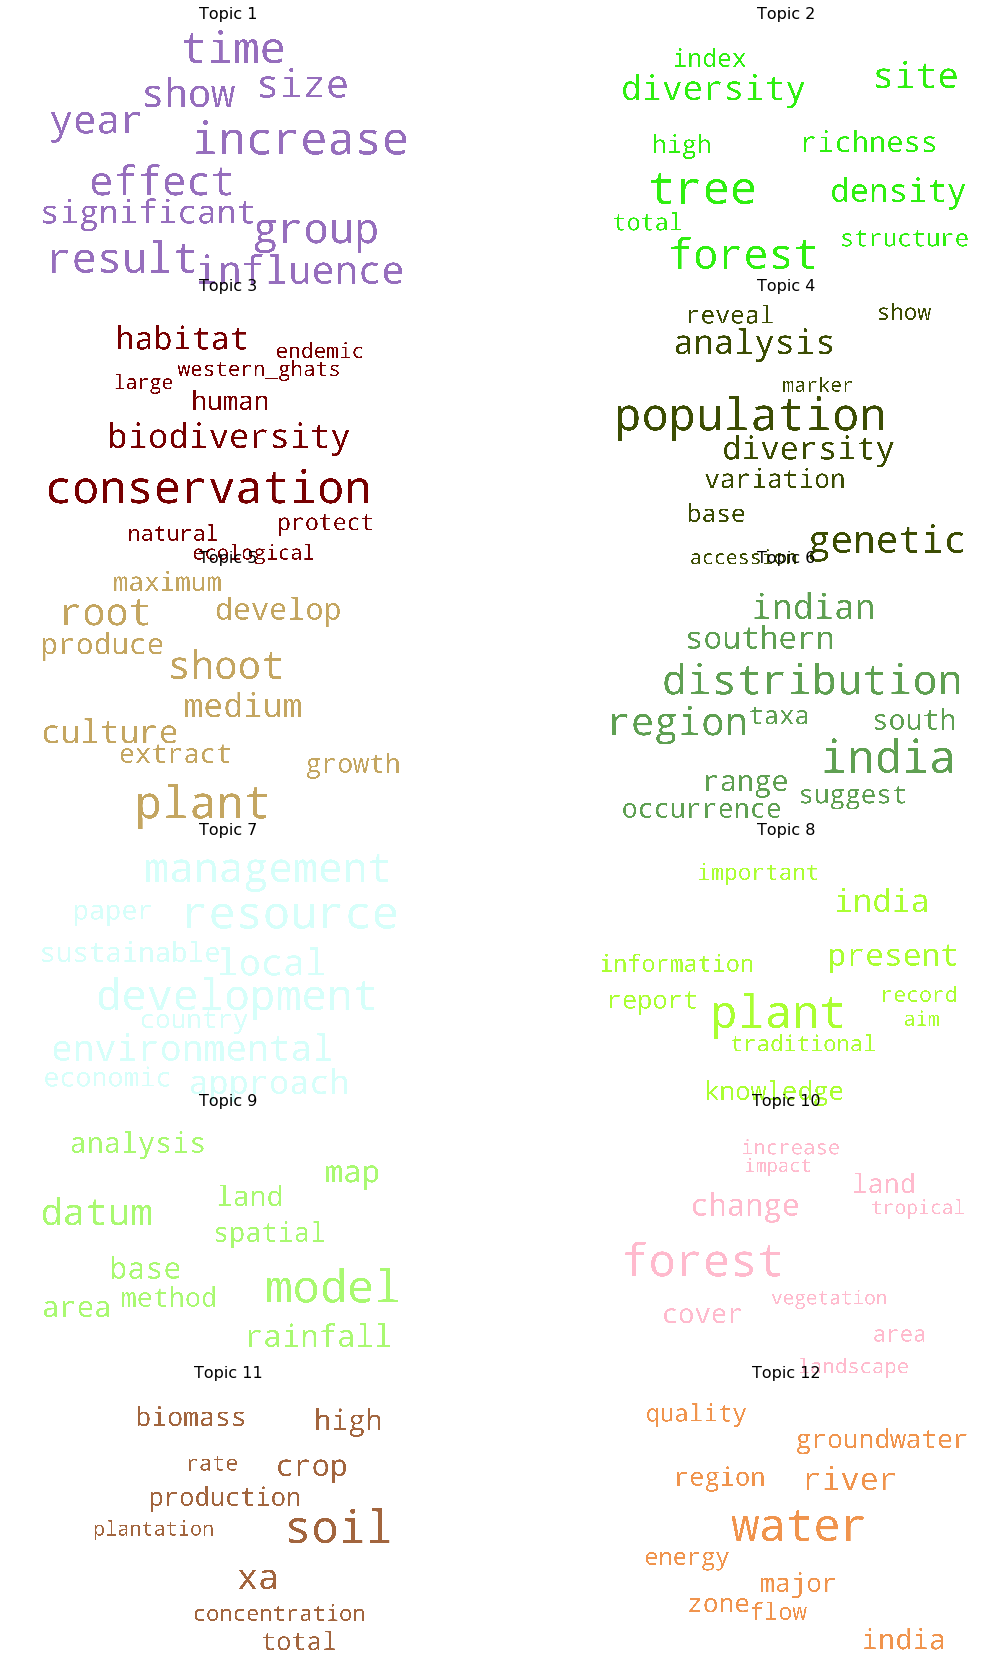

In [39]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab8',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(6, 2, figsize = (20, 30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

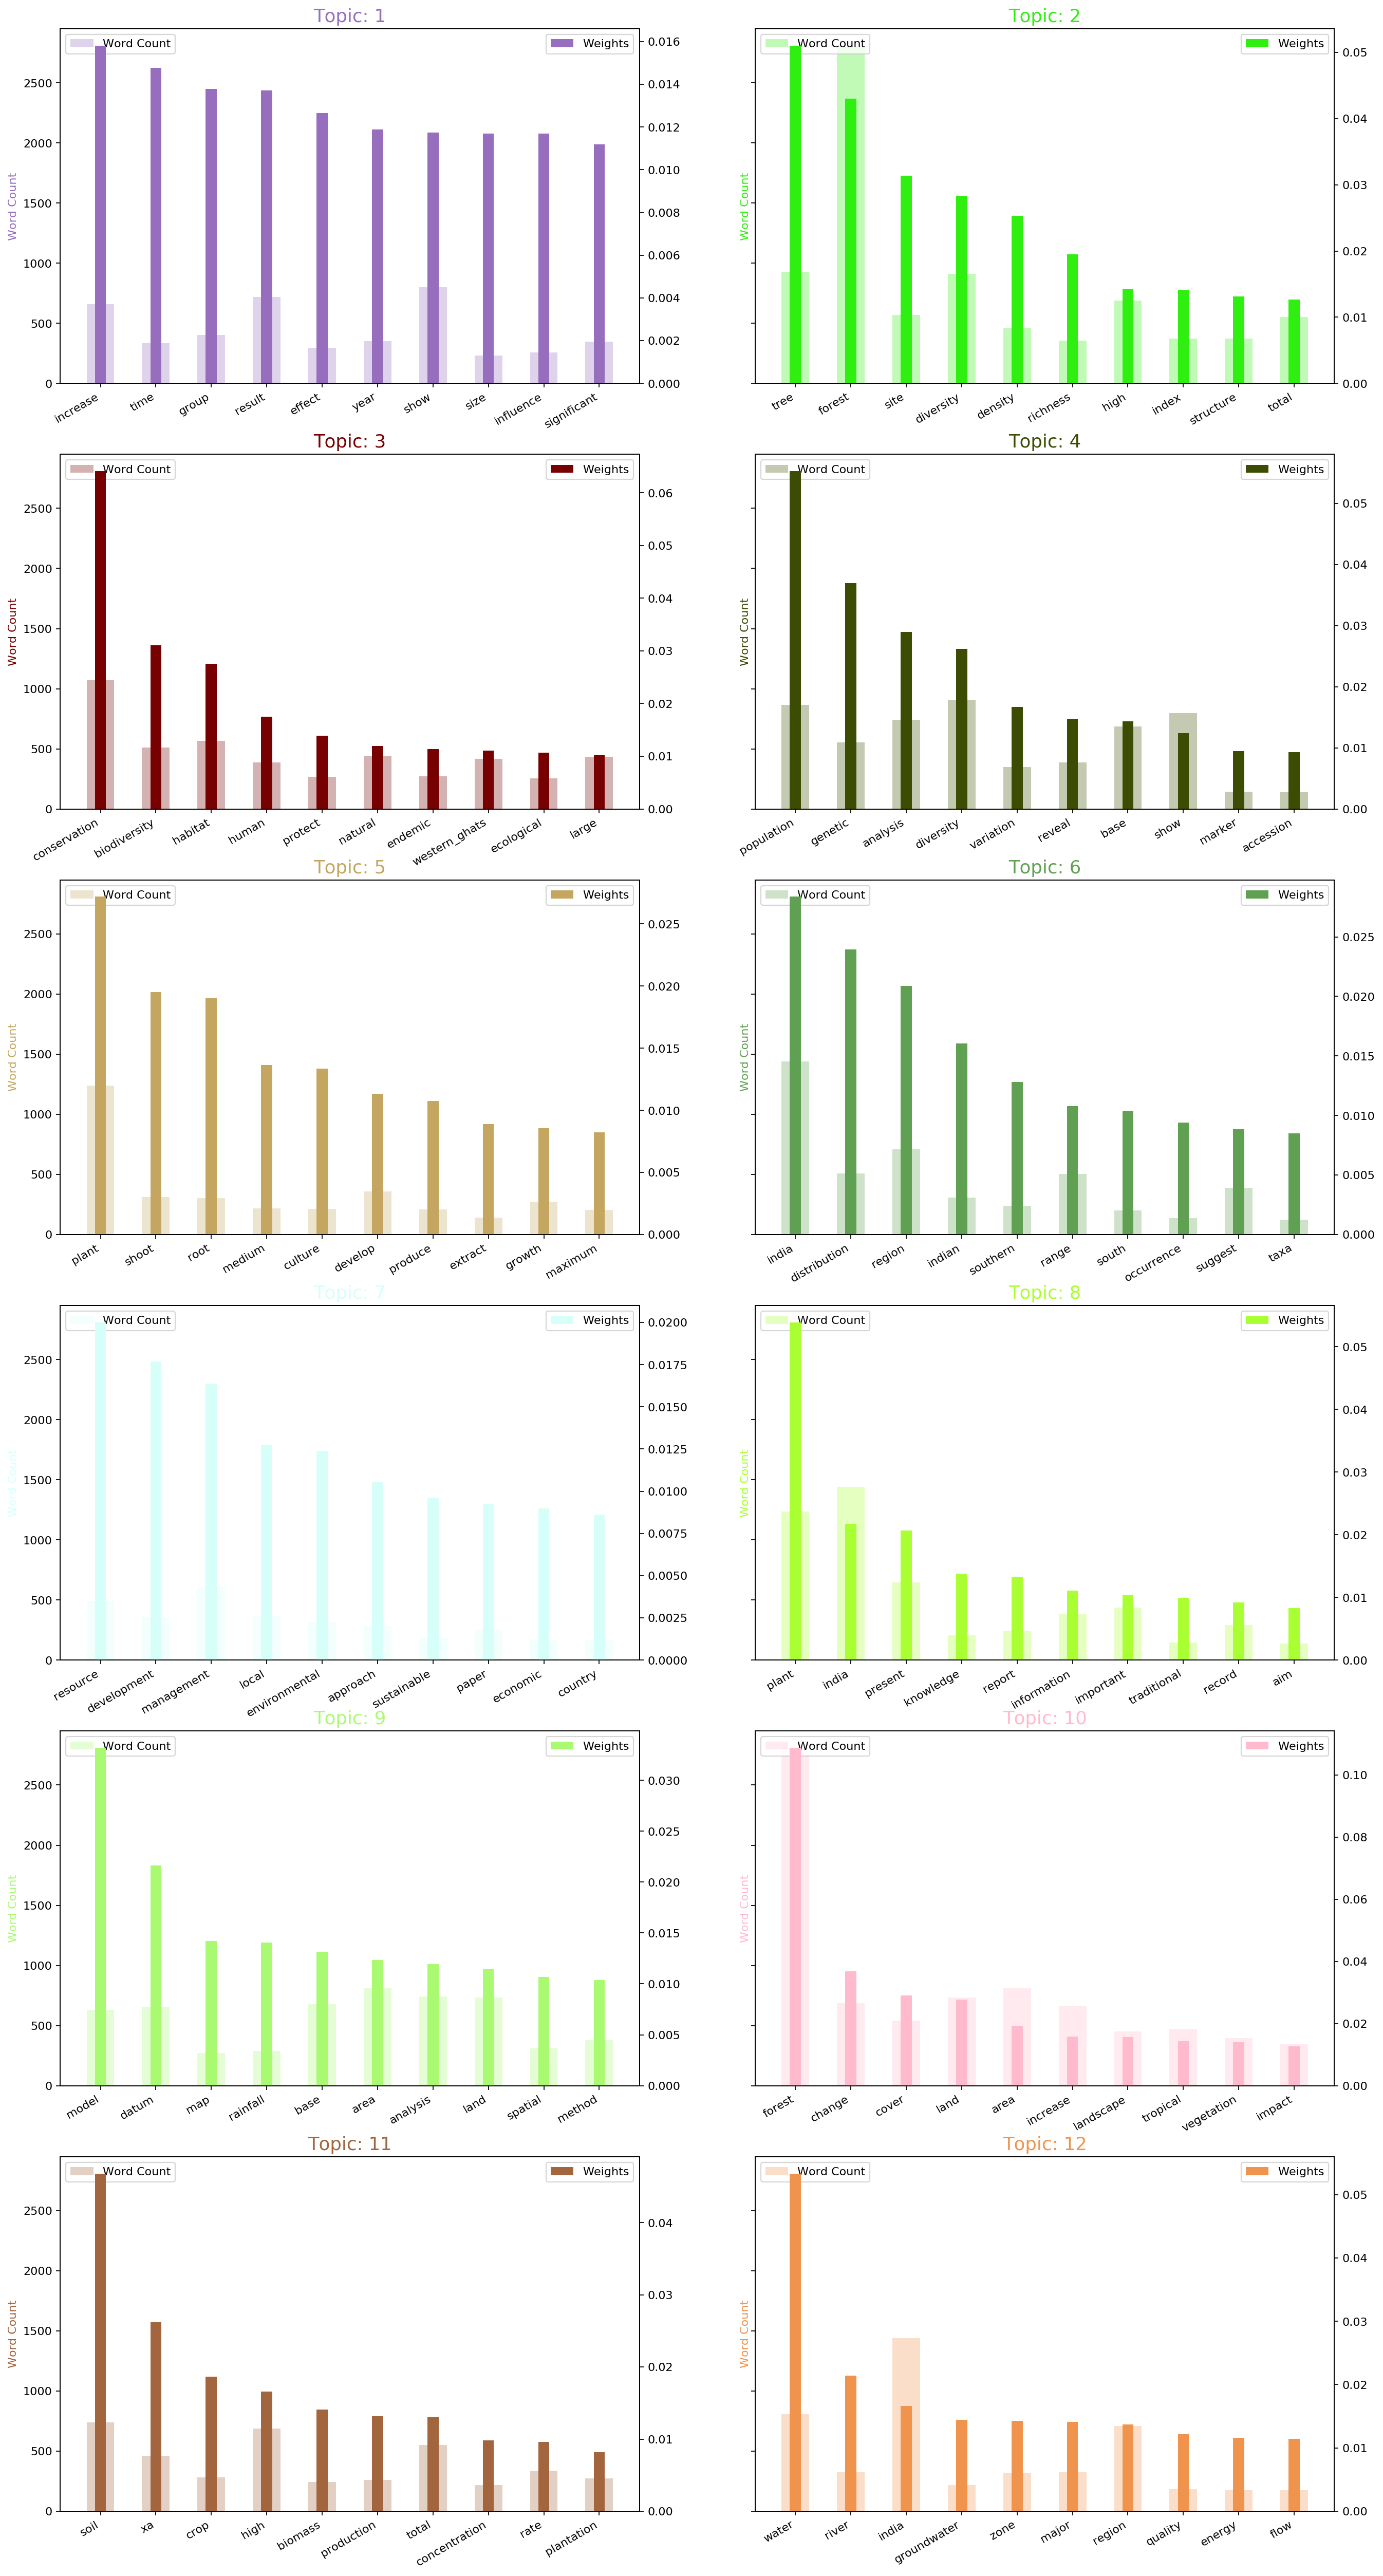

In [41]:
from collections import Counter
topics = optimal_model.show_topics(num_topics = -1, formatted=False)
data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(20, 40), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
plt.savefig(session_folder_name + '/WesternTopic12.pdf')
plt.show()